In [22]:
import os
import math
import pandas

import matplotlib.pyplot as plt

from src.data.annotations import load_dataset_annotations
from src.data.annotations import make_continious_labels
from src.visualization.events import legend_without_duplicate_labels
from src.features.soundlevel import compute_background
from src.utils.fileutils import get_project_root

In [2]:
annotations = load_dataset_annotations()
# annotations

skipping archive
skipping MAESTRO_annotation_notes.md
skipping archive
skipping b093_annotations_BD.txt.bak
skipping TUT_annotation_notes.md


In [3]:
def load_noise_classes():
    p = os.path.join(get_project_root(), 'data/processed/noise_classes.csv')
    df = pandas.read_csv(p, sep=';', quotechar="'")
    df['noise'] = df.noise.fillna('other')
    df = df.set_index('original')
    return df

m = load_noise_classes()
m.noise.value_counts()

noise
other           37
speech          16
road_traffic    11
rail_traffic     5
biophony         5
geophony         4
music            2
Name: count, dtype: int64

In [4]:
def make_multitrack_labels(df, classes=None, time_resolution=0.100):
    last = df['end'].max()
    out = make_continious_labels(df, length=math.ceil(last/time_resolution),
                                 time_resolution=time_resolution,
                                 class_column='noise_class',
                                 classes=classes)
    
    return out


aa = annotations.copy()
aa['noise_class'] = aa.annotation.map(m.noise.to_dict())
all_classes = sorted(aa.noise_class.unique())
multi_track = aa.groupby(['dataset', 'clip']).apply(make_multitrack_labels, classes=all_classes)
# multi_track

In [5]:
def single_track_labels(multi : pandas.DataFrame, mixed_class='mixed'):

    classes_active = multi.sum(axis=1)
    out = pandas.Series(['background']*len(multi), index=multi.index, dtype=pandas.StringDtype())

    # Simple definition of mixed: anytime there is any form of overlap in the labels (eg, >= 2)
    out.loc[classes_active >= 2] = mixed_class
    
    out.loc[classes_active == 1] = multi.idxmax(axis=1)
    return out


single_track = multi_track.groupby(['dataset', 'clip'], group_keys=False).apply(single_track_labels)
single_track

dataset  clip                time                  
maestro  cafe_restaurant_08  0 days 00:00:00             background
                             0 days 00:00:00.100000      background
                             0 days 00:00:00.200000      background
                             0 days 00:00:00.300000      background
                             0 days 00:00:00.400000      background
                                                           ...     
tut      b093                0 days 00:03:30.400000           mixed
                             0 days 00:03:30.500000    road_traffic
                             0 days 00:03:30.600000    road_traffic
                             0 days 00:03:30.700000    road_traffic
                             0 days 00:03:30.800000    road_traffic
Length: 34998, dtype: string

In [6]:
def import_soundlevels(speed: str = 'LAF'):
    return pandas.read_parquet(os.path.join(get_project_root(), f'data/processed/soundlevels/{speed}.parquet'))

In [7]:
def resample_levels(df: pandas.DataFrame, freq='100ms'):
    out = df.copy()
    out = out.reset_index(allow_duplicates=True).set_index('time')
    out = out[['level', 'background', 'delta']]
    
    # isinstance(out.index, pandas.DatetimeIndex)

    return out.resample(freq).mean()

In [8]:
def map_levels_to_labels(single: pandas.DataFrame, speed='LAF'):
    '''
    Imports the saved soundlevels for LAF/LAS, computes background levels, resamples levels
    to match the Timedelta of the single track labels, then renames/relabels instances of "background"
    which are actually sound events.
    '''
    
    soundlevels = import_soundlevels(speed=speed)
    
    # compute background levels and delta
    sb = soundlevels.groupby(['dataset', 'clip'])['level'].apply(compute_background, window=30.0)
    
    # apply resampling then recompute delta
    sb = sb.groupby(['dataset', 'clip'])[['level', 'background', 'delta']].apply(resample_levels)
    sb['delta'] = sb['level'] - sb['background']
    
    # merge the resampled levels with the labels
    df = pandas.DataFrame(single).merge(sb, how='left', left_index=True, right_index=True)

    # mark timestamps where delta exceeds +5db (sound events)
    df['event'] = df['delta'] >= 5

    # if a timestamp is labelled as "background", but also a sound event - re-label to "unknown"
    df['unknown'] = (df[0] == 'background') & (df['event'] == True)
    df[0] = df[0].mask(df['unknown'], other='unknown')

    df = df.rename(columns={0: 'label'})
    
    df = df[['label', 'level', 'background', 'delta']]

    return df
    

In [9]:
test = map_levels_to_labels(single = single_track)

In [11]:
LAS = test

<Axes: title={'center': 'LAS Overall Distribution'}, ylabel='count'>

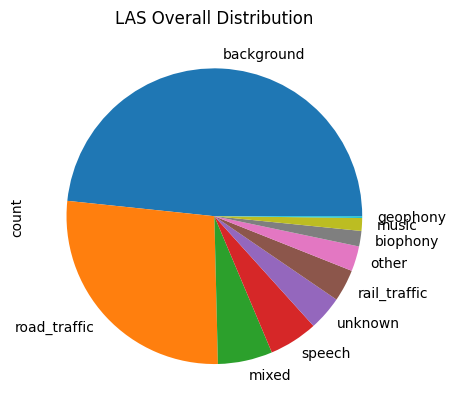

In [16]:
LAS['label'].value_counts().plot(kind='pie', title='LAS Overall Distribution')

In [17]:
def dense_to_events(df : pandas.DataFrame,
                    category_column='label',
                    time_column='time',
                   ) -> pandas.DataFrame:
    """
    Convert a dense time-series with categories into events with start,end
    """
    df = df.copy() # avoid mutating input
    df['start'] = df[time_column]
    df['end'] = df[time_column]
    changes = df[category_column].ne(df[category_column].shift()).dropna()
    label_groups = changes.cumsum()

    out = df.groupby(label_groups).agg({'start':'min', 'end':'max', category_column:'first'}).reset_index(drop=True)

    return out

In [29]:
from src.visualization.events import plot_events

class_color_map = {
    'background': (0.95, 0.95, 0.95),
    'mixed': 'black',
    'speech': 'blue',
    'music': 'green',
    'rail_traffic': 'red',
    'road_traffic': 'orange',
    'other': 'teal',
    'biophony': 'yellow',
    'geophony': 'purple',
    'unknown': 'magenta'
}

def plot(s):
    
    s = s['label']

    fig, ax = plt.subplots(1, figsize=(15, 2))

    # A) convert back to indicator columns. Use existing multi track plotting
    # will make switches clear - but not obvious that the classes are mutually exclusive
    multi = pandas.get_dummies(s)
    multi = multi.reset_index().set_index('time').drop(columns=['dataset', 'clip'])    
    #plot_multitrack_labels(ax, multi)


    # B) group into runs. Use vspan to plot colored sections
    df = s.to_frame()
    df.columns = ['label']
    df = df.reset_index()
    df['time'] = df.time / pandas.Timedelta(seconds=1) # matplotlib / plot_events() does not like Timedeltas
    df = df.drop(columns=['dataset', 'clip'])

    cons = dense_to_events(df)
    cons['color'] = cons.label.map(class_color_map)
    
    plot_events(ax, cons, color='color', label='label', alpha=1.0)
    legend_without_duplicate_labels(ax)

""


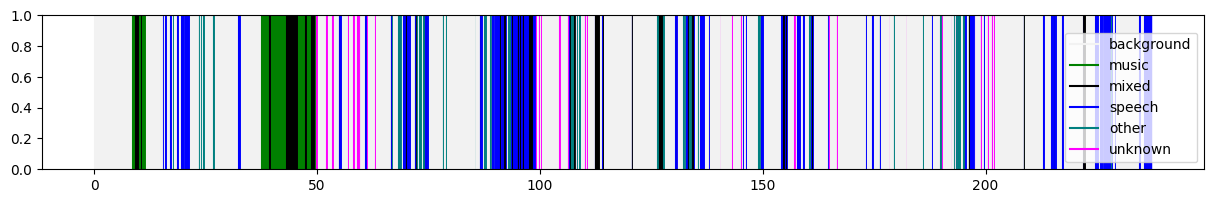

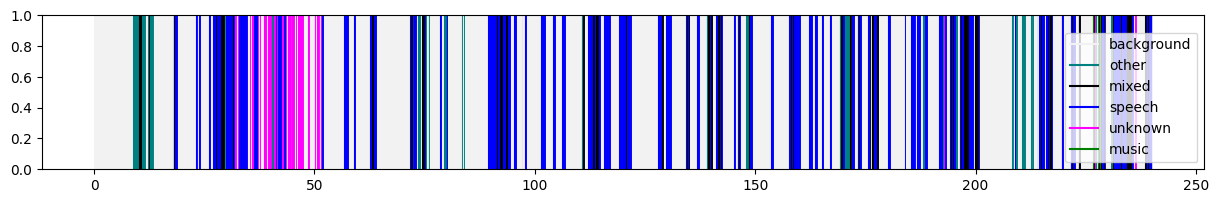

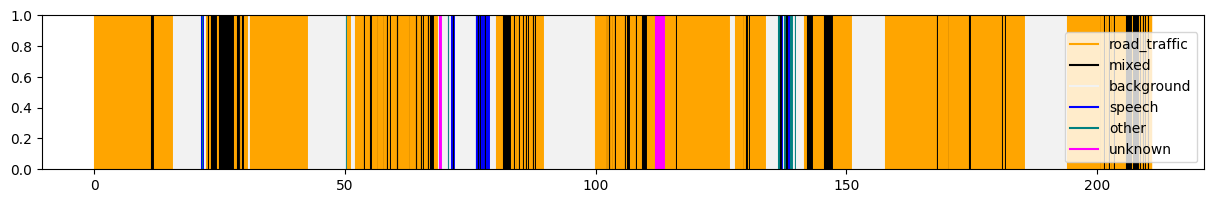

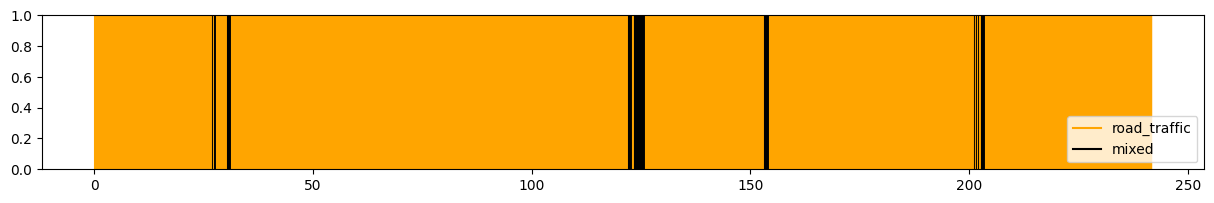

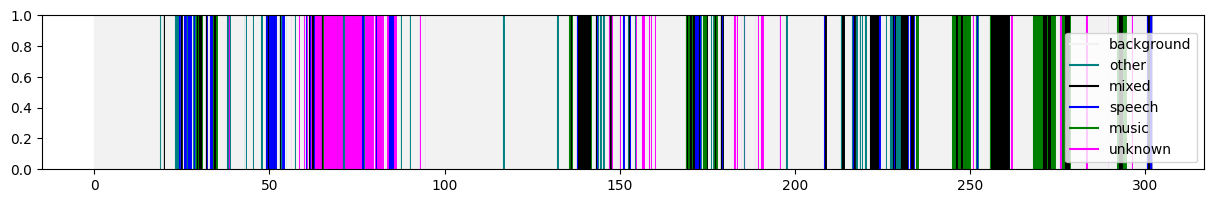

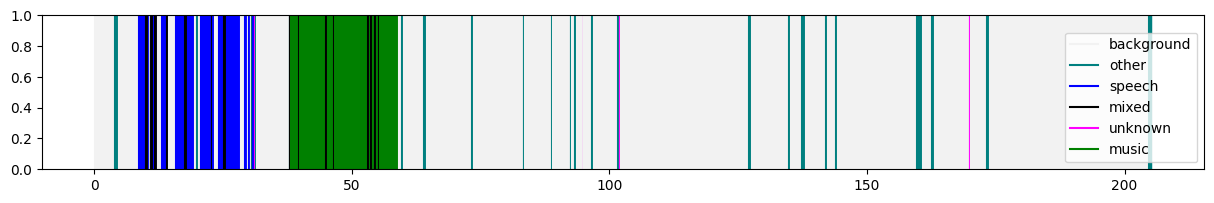

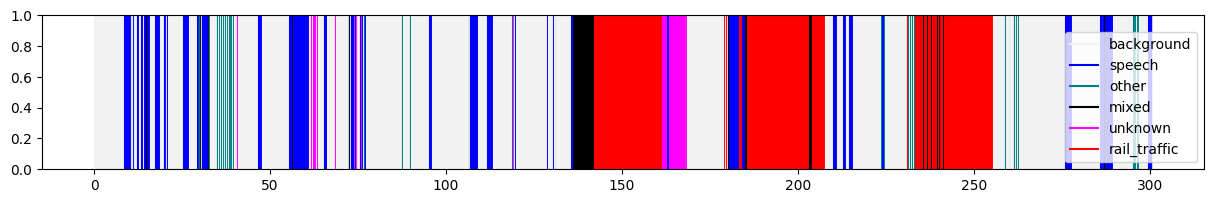

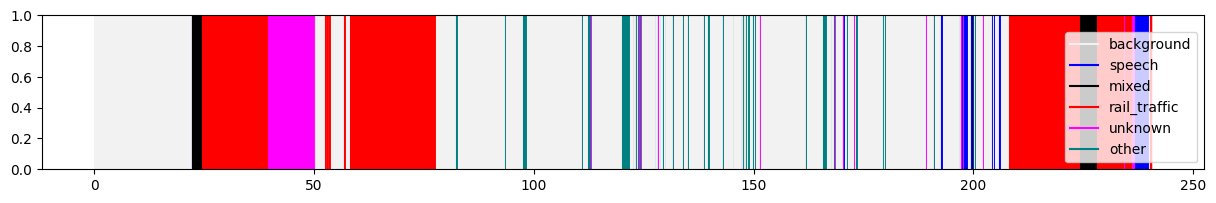

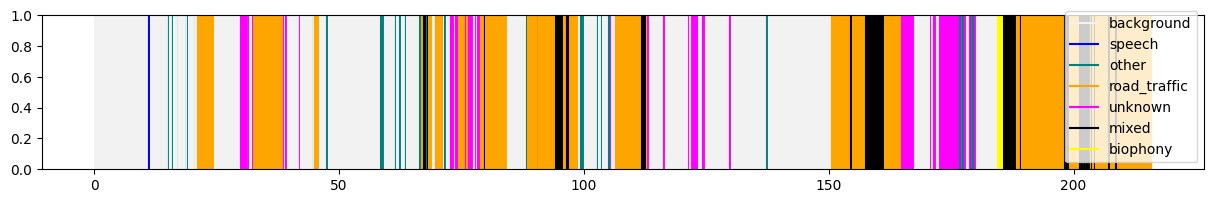

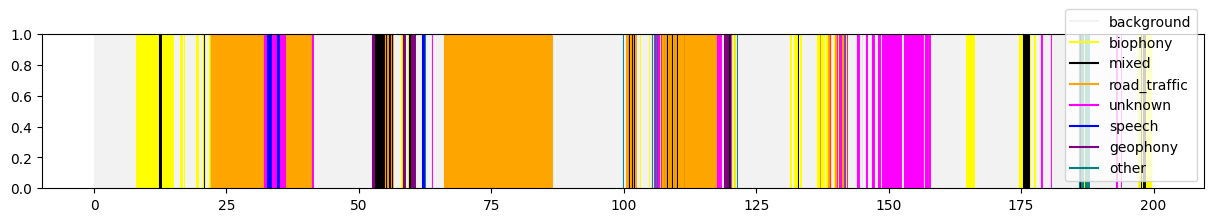

In [30]:
    

MAESTRO = LAS.loc[['maestro']]
MAESTRO.groupby(['dataset', 'clip']).apply(plot)

In [16]:
# Load from files
soundlevels = import_soundlevels(speed='LAF')
soundlevels

level
config dataset clip               time                                
LAF    maestro cafe_restaurant_08 0 days 00:00:00           -62.804841
                                  0 days 00:00:00.031247166 -62.394445
                                  0 days 00:00:00.062494331 -62.302897
                                  0 days 00:00:00.093741497 -62.695602
                                  0 days 00:00:00.124988662 -63.145625
...                                                                ...
       tut     b093               0 days 00:03:30.699637188 -51.979439
                                  0 days 00:03:30.730884354 -51.726695
                                  0 days 00:03:30.762131519 -51.561552
                                  0 days 00:03:30.793378685 -51.551983
                                  0 days 00:03:30.824625850 -51.378598

[112512 rows x 1 columns]

In [18]:
# compute background levels and delta
sb = soundlevels.groupby(['dataset', 'clip'])['level'].apply(compute_background, window=30.0)
sb

level  \
dataset clip               config dataset clip               time                                   
maestro cafe_restaurant_08 LAF    maestro cafe_restaurant_08 0 days 00:00:00           -62.804841   
                                                             0 days 00:00:00.031247166 -62.394445   
                                                             0 days 00:00:00.062494331 -62.302897   
                                                             0 days 00:00:00.093741497 -62.695602   
                                                             0 days 00:00:00.124988662 -63.145625   
...                                                                                           ...   
tut     b093               LAF    tut     b093               0 days 00:03:30.699637188 -51.979439   
                                                             0 days 00:03:30.730884354 -51.726695   
                                                             0 days 00:03:30.762131519 -51.561552   
                                                             0 days 00:03:30.793378685 -51.551983   
                                                             0 days 00:03:30.824625850 -51.378598   

                                                                                        background  \
dataset clip               config dataset clip               time                                    
maestro cafe_restaurant_08 LAF    maestro cafe_restaurant_08 0 days 00:00:00                   NaN   
                                                             0 days 00:00:00.031247166         NaN   
                                                             0 days 00:00:00.062494331         NaN   
                                                             0 days 00:00:00.093741497         NaN   
                                                             0 days 00:00:00.124988662         NaN   
...                                                                                            ...   
tut     b093               LAF    tut     b093               0 days 00:03:30.699637188  -63.305769   
                                                             0 days 00:03:30.730884354  -63.305769   
                                                             0 days 00:03:30.762131519  -63.305769   
                                                             0 days 00:03:30.793378685  -63.305769   
                                                             0 days 00:03:30.824625850  -63.305769   

                                                                                            delta  
dataset clip               config dataset clip               time                                  
maestro cafe_restaurant_08 LAF    maestro cafe_restaurant_08 0 days 00:00:00                  NaN  
                                                             0 days 00:00:00.031247166        NaN  
                                                             0 days 00:00:00.062494331        NaN  
                                                             0 days 00:00:00.093741497        NaN  
                                                             0 days 00:00:00.124988662        NaN  
...                                                                                           ...  
tut     b093               LAF    tut     b093               0 days 00:03:30.699637188  11.326330  
                                                             0 days 00:03:30.730884354  11.579074  
                                                             0 days 00:03:30.762131519  11.744216  
                                                             0 days 00:03:30.793378685  11.753786  
                                                             0 days 00:03:30.824625850  11.927170  

[112512 rows x 3 columns]

In [26]:
# apply resampling
sb = sb.groupby(['dataset', 'clip'])[['level', 'background', 'delta']].apply(resample_clip)

# recompute delta from the resampled levels and background
sb['delta'] = sb['level'] - sb['background']
sb

level  background  \
dataset clip               time                                            
maestro cafe_restaurant_08 0 days 00:00:00        -62.549446         NaN   
                           0 days 00:00:00.100000 -62.990557         NaN   
                           0 days 00:00:00.200000 -62.900260         NaN   
                           0 days 00:00:00.300000 -62.716761         NaN   
                           0 days 00:00:00.400000 -62.489824         NaN   
...                                                      ...         ...   
tut     b093               0 days 00:03:30.400000 -52.160851  -63.305769   
                           0 days 00:03:30.500000 -52.331346  -63.305769   
                           0 days 00:03:30.600000 -52.164475  -63.305769   
                           0 days 00:03:30.700000 -51.613410  -63.305769   
                           0 days 00:03:30.800000 -51.378598  -63.305769   

                                                       delta  
dataset clip               time                               
maestro cafe_restaurant_08 0 days 00:00:00               NaN  
                           0 days 00:00:00.100000        NaN  
                           0 days 00:00:00.200000        NaN  
                           0 days 00:00:00.300000        NaN  
                           0 days 00:00:00.400000        NaN  
...                                                      ...  
tut     b093               0 days 00:03:30.400000  11.144917  
                           0 days 00:03:30.500000  10.974422  
                           0 days 00:03:30.600000  11.141293  
                           0 days 00:03:30.700000  11.692358  
                           0 days 00:03:30.800000  11.927170  

[35159 rows x 3 columns]

In [29]:
df = pandas.DataFrame(single_track).merge(sb, how='left', left_index=True, right_index=True)

# mark timestamps where delta exceeds +5db (sound events)
df['event'] = df['delta'] >= 5

# if a timestamp is labelled as "background", but also a sound event - re-label to "unknown"
df['unknown'] = (df[0] == 'background') & (df['event'] == True)
df[0] = df[0].mask(df['unknown'], other='unknown')

df = df.rename(columns={0: 'label'})

df.label.value_counts()

label
background      16919
road_traffic     9464
mixed            2090
speech           1868
unknown          1320
rail_traffic     1229
other             958
biophony          592
music             491
geophony           67
Name: count, dtype: Int64

In [30]:
df.columns

Index(['label', 'level', 'background', 'delta', 'event', 'unknown'], dtype='object')

In [31]:
df = df[['label', 'level', 'background', 'delta']]